## Feature engineering

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ptbxl.utils.paths import data_interim_dir, data_raw_dir, data_processed_dir
from ptbxl.data.make_dataset import load_raw_data
from ptbxl.data.signal_preprocessing import SignalPreprocessing
from ptbxl.features.build_features import BuildFeatures
from scipy import signal

sns.set_theme()

preprocessing = SignalPreprocessing()
feature_builder = BuildFeatures()

In [17]:
# Load metatadata
dataset_metadata = pd.read_csv(data_interim_dir("dataset_metadata.csv"))
print(f"Number of records: {len(dataset_metadata)}")
display(dataset_metadata.head())

Number of records: 9553


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,max_likelihood,target
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,AFLT,1.0
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,AFLT,1.0
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,AFLT,1.0
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,AFLT,1.0
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,AFLT,1.0


In [18]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [19]:
# Load ECG signals
fs = 100 # Sampling rate (Hz)
ecg_signals = load_raw_data(
    dataset_metadata, 
    sampling_rate=fs, 
    path=data_raw_dir("physionet.org/files/ptb-xl/1.0.3"),
)
ecg_signals = ecg_signals[:, 1*fs:-1*fs, :] # Remove first and last second

m, n, lead = ecg_signals_data_shape = ecg_signals.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f"Signald block shape (m, n, lead): {ecg_signals_data_shape}")
print(f"Signals duration: {dur}")


Signald block shape (m, n, lead): (9553, 800, 12)
Signals duration: 8.0


## Preprocessing

In [20]:
ecg_signals_w0 = preprocessing.wander_removal(ecg_signals, fs, axis=1)
ecg_signals_m0 = preprocessing.mean_removal(ecg_signals_w0, axis=1)

w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg_signals_pt = preprocessing.pan_tompkins(ecg_signals_m0, fs, w, axis=1)

## Dominant frequency

To compute the **dominant frequency** of a signal, we need to analyze the frequency components of the processed ECG signal, which is achieved by calculating the **Power Spectral Density (PSD)**. The dominant frequency is simply the frequency at which the PSD is maximized, representing the most significant frequency component of the signal.

Here's a step-by-step explanation of how this function computes the dominant frequency:

### Step 1: Power Spectral Density (PSD) Estimation
The function estimates the PSD using either:
1. **FFT-based periodogram** (via `signal.periodogram`), or
2. **Welch’s method** (via `signal.welch`), which averages periodograms over several overlapping segments for a smoother estimate.

Let:
- $ x[n] $ represent the processed ECG signal in the time domain,
- $ f_s $ be the sampling frequency in Hz,
- $ N $ be the length of $ x[n] $.

#### Option 1: Periodogram (FFT-based PSD Estimation)
Using the periodogram method, the PSD $ P_{xx}(f) $ is estimated directly from the Fourier transform of $ x[n] $:
$$
P_{xx}(f_k) = \frac{1}{N f_s} \left| X(f_k) \right|^2 \quad \text{for } k = 0, 1, \dots, N/2
$$
where:
- $ X(f_k) $ is the Discrete Fourier Transform (DFT) of $ x[n] $ at frequency $ f_k = \frac{k f_s}{N} $.

#### Option 2: Welch's Method (Averaged Periodograms)
When using Welch’s method, the signal $ x[n] $ is divided into overlapping segments, each of length $ L $ (specified by `nperseg`). The periodogram of each segment is computed, and then the periodograms are averaged to obtain a smoother PSD estimate:
$$
P_{xx}(f_k) = \frac{1}{M} \sum_{m=1}^{M} \frac{1}{L f_s} \left| X_m(f_k) \right|^2
$$
where $ M $ is the number of segments, and $ X_m(f_k) $ is the DFT of the $ m $-th segment.

### Step 2: Identify the Dominant Frequency
Once the PSD $ P_{xx}(f) $ is computed, the next step is to find the frequency at which it is maximized. This frequency is the **dominant frequency** of the signal:
$$
f_{\text{dominant}} = \arg \max_{f_k} P_{xx}(f_k)
$$
where $ f_{\text{dominant}} $ is the frequency at which $ P_{xx}(f) $ reaches its maximum value.

### Summary of the Function
- **Input**: The processed ECG signal $ x[n] $ and sampling frequency $ f_s $.
- **Output**: The dominant frequency $ f_{\text{dominant}} $, which is the frequency with the highest power in the PSD.

This dominant frequency feature can be useful in ECG analysis, as it may indicate physiological properties or the presence of artifacts in the ECG signal.

In [21]:
idx = np.random.randint(0, m)

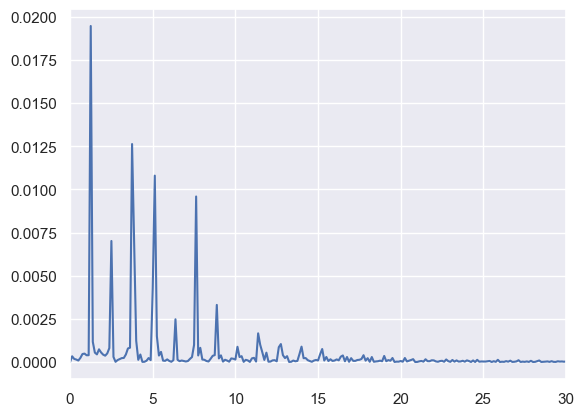

In [22]:
# Freq. content after mean removal and wander removal
x_w0 = ecg_signals_m0[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x_w0, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

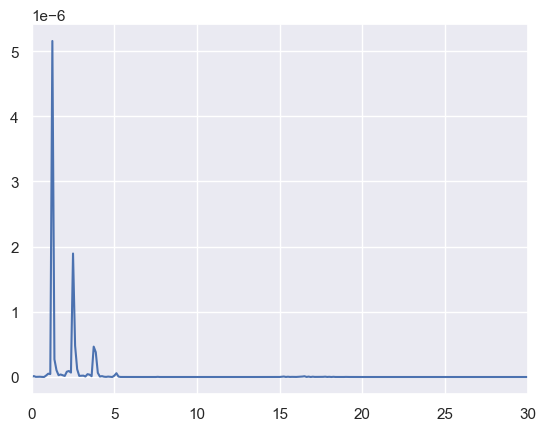

In [23]:
# Freq. content after mean removal and wander removal + PT algorithm
x_pt = ecg_signals_pt[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x_pt, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

### Compute the domint frequency to the ECG tensor

In [24]:
dominant_freq = feature_builder.dominant_frequency(
    ecg_signals_pt,
    fs=fs,
    axis=1
)

print(dominant_freq.shape)

(9553, 12)


In [25]:
df_dominant_freq = pd.DataFrame(dominant_freq, columns=["DF_" + lead for lead in leads])
display(df_dominant_freq)

,DF_I,DF_II,DF_III,DF_aVF,DF_aVR,DF_aVL,DF_V1,DF_V2,DF_V3,DF_V4,DF_V5,DF_V6
0,2.375,2.375,2.375,2.375,2.375,0.125,2.375,2.375,2.375,2.375,2.375,2.375
1,2.125,2.125,0.125,2.125,2.125,0.125,2.125,2.125,2.125,2.125,2.125,2.125
2,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
3,2.125,2.125,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
4,2.250,2.250,0.250,2.250,2.250,0.250,2.250,2.250,2.250,2.250,2.250,2.250
...,...,...,...,...,...,...,...,...,...,...,...,...
9548,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125
9549,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375
9550,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125
9551,1.125,1.125,1.000,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125


In [26]:
dominant_freq_dataset = pd.concat([dataset_metadata, df_dominant_freq], axis=1)
display(dominant_freq_dataset)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,DF_III,DF_aVF,DF_aVR,DF_aVL,DF_V1,DF_V2,DF_V3,DF_V4,DF_V5,DF_V6
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,2.375,2.375,2.375,0.125,2.375,2.375,2.375,2.375,2.375,2.375
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,0.125,2.125,2.125,0.125,2.125,2.125,2.125,2.125,2.125,2.125
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,0.250,2.250,2.250,0.250,2.250,2.250,2.250,2.250,2.250,2.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9548,21830,10520.0,86.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 07:53:21,...,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125
9549,21831,11905.0,55.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 12:49:25,...,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375
9550,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125
9551,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,1.000,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125


In [28]:
dominant_freq_dataset.to_csv(data_processed_dir("dominant_freq_dataset.csv"), index=False)